# 4. Thresholding

Al realizar operaciones lógicas del tipo ```image > value```  hemos visto que esto nos permitía realizar **thresholding**, uno de los métodos básicos de procesado de imágenes para identificar objetos en una imagen. Aquí volvemos sobre este tema y mostramos cómo podemos automatizar la selección del umbral, combinar máscaras, etc.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request

In [25]:
url = 'https://github.com/guiwitz/PyImageCourse_beginner/raw/master/images/46658_784_B12_1.tif'
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image_stack = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image_stack = cv2.cvtColor(image_stack, cv2.COLOR_BGR2RGB)

In [26]:
image_stack.shape

(2048, 2048, 3)

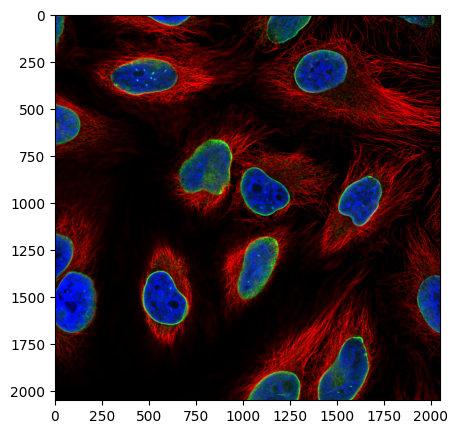

In [27]:
plt.subplots(figsize=(5,5))
plt.imshow(image_stack)

Volvemos a tener una imagen de tres canales, es decir, nuestra imagen se compone de tres planos. De momento sólo queremos trabajar con los núcleos, así que aislamos ese canal, el tercero:

In [32]:
image_nuclei = image_stack[:,:,2]

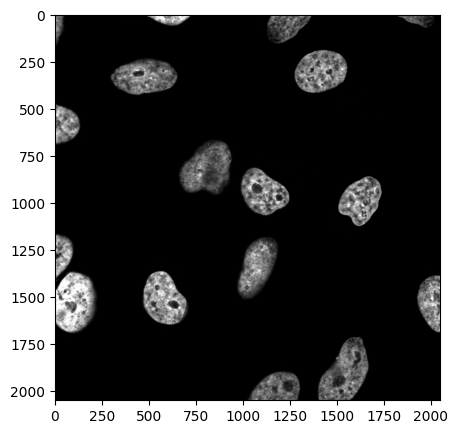

In [33]:
plt.subplots(figsize=(5,5))
plt.imshow(image_nuclei, cmap = 'gray')

## Investigación manual

Hemos visto en el capítulo anterior que si queremos aislar núcleos, tenemos que saber más o menos qué intensidad tienen para poder utilizar un valor de corte en las intensidades de los píxeles. Podemos observar el histograma de los valores de los píxeles:

(array([3593317.,   54030.,   87251.,  112196.,  119289.,   89619.,
          60085.,   34064.,   20522.,   23931.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

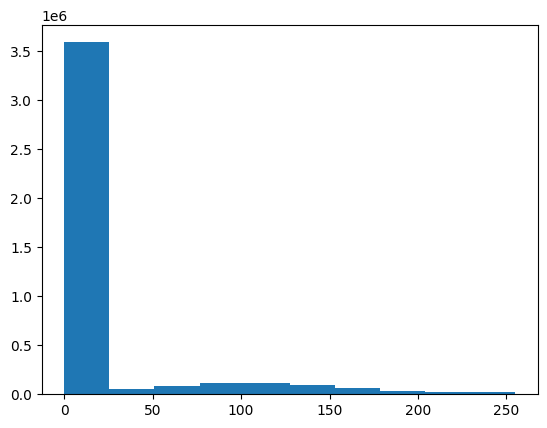

In [ ]:
plt.hist(np.ravel(image_nuclei))

Claramente tenemos una intensidad de fondo entre 0 y ~50, y la señal repartida entre 50 y 255. Podemos crear una máscara de todos los píxeles con un valor superior a 50:

In [ ]:
mask = image_nuclei > 50

In [34]:
mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

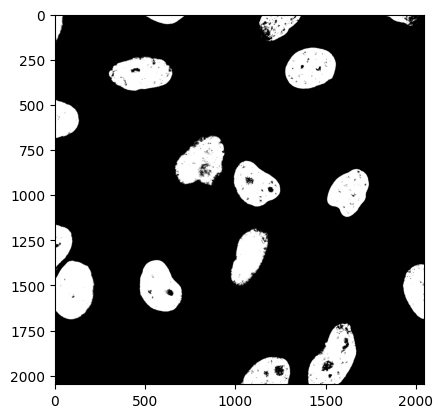

In [ ]:
plt.imshow(mask, cmap = 'gray')

Por el bien del experimento, utilicemos un umbral más alto:

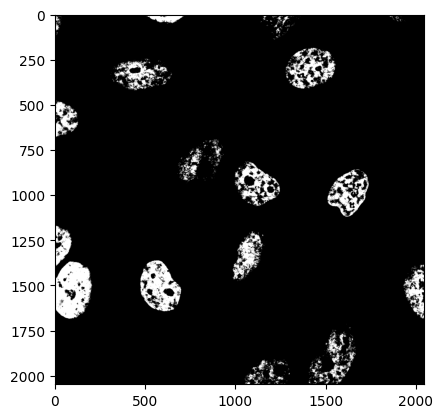

In [35]:
mask = image_nuclei > 120
plt.imshow(mask, cmap = 'gray')

Evidentemente, si el umbral es demasiado alto, perdemos partes importantes de la imagen.

## Ajuste automático del umbral

Fijar un umbral manualmente no es lo ideal por dos razones:
1. tus ojos pueden engañarte
2. si tiene que realizar esta operación en cientos de imágenes, no querrá hacerlo a mano.

Se han desarrollado varios métodos para detectar un umbral «ideal» basándose en el histograma de píxeles. Uno de los más famosos es el método Otsu: establece un umbral dividiendo los píxeles en dos clases e intenta minimizar la varianza de ambas clases.

Todos estos algoritmos clásicos están implementados en scikit-image y podemos utilizarlos directamente. Todos los algoritmos se agrupan en grupos lógicos (filtrado, medición, etc.) A menudo lo más fácil es simplemente usar Google para encontrarlos.

Por ejemplo el [algoritmo Otsu](https://www.google.com/search?q=skimage+otsu&oq=skimage+otsu&aqs=chrome..69i57j69i60j0l4.2268j0j7&sourceid=chrome&ie=UTF-8):

In [ ]:
help(cv2.threshold)

Help on built-in function threshold:

threshold(...)
    threshold(src, thresh, maxval, type[, dst]) -> retval, dst
    .   @brief Applies a fixed-level threshold to each array element.
    .   
    .   The function applies fixed-level thresholding to a multiple-channel array. The function is typically
    .   used to get a bi-level (binary) image out of a grayscale image ( #compare could be also used for
    .   this purpose) or for removing a noise, that is, filtering out pixels with too small or too large
    .   values. There are several types of thresholding supported by the function. They are determined by
    .   type parameter.
    .   
    .   Also, the special values #THRESH_OTSU or #THRESH_TRIANGLE may be combined with one of the
    .   above values. In these cases, the function determines the optimal threshold value using the Otsu's
    .   or Triangle algorithm and uses it instead of the specified thresh.
    .   
    .   @note Currently, the Otsu's and Triangle methods a

In [36]:
my_otsu_threshold,_= cv2.threshold(image_nuclei, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(my_otsu_threshold)

66.0


Utilizando ese valor podemos crear una nueva máscara:

In [37]:
mask_nuclei = image_nuclei > my_otsu_threshold

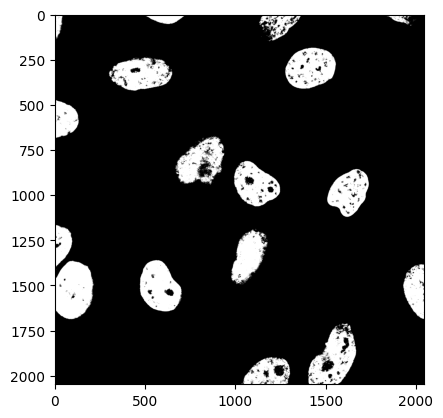

In [38]:
plt.imshow(mask_nuclei, cmap = 'gray')

## Combinación de máscaras

Podemos hacer la misma operación de umbralización en el otro canal contenido en la imagen. Vamos primero a «aislar» el primer canal (rojo):

In [39]:
image_cells = image_stack[:,:,0]

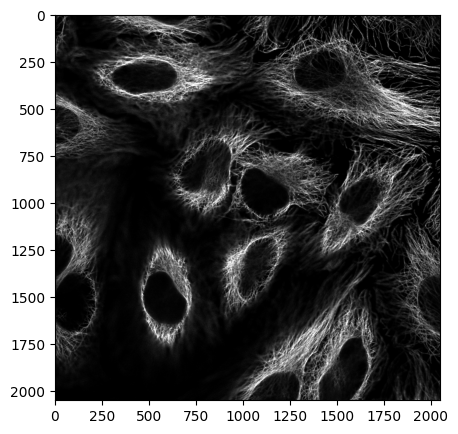

In [40]:
plt.subplots(figsize=(5,5))
plt.imshow(image_cells, cmap = 'gray')

In [41]:
threshold2,_=cv2.threshold(image_cells, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask_cells = image_cells > threshold2

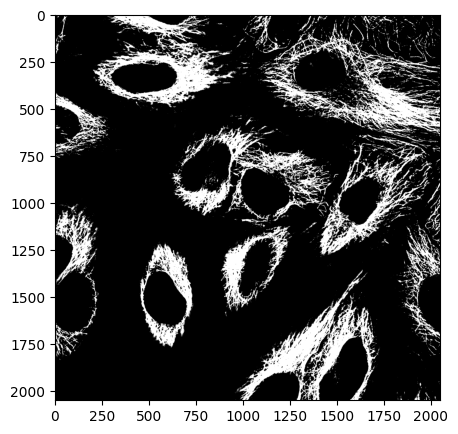

In [42]:
plt.subplots(figsize=(5,5))
plt.imshow(mask_cells, cmap = 'gray')

En principio, podemos combinar las máscaras como queramos. Por ejemplo, podemos considerar los píxeles que están ENCENDIDOS (```True```) en ambas máscaras multiplicándolos sólo como ```True x True = True```.

In [43]:
both_masks = mask_cells * mask_nuclei

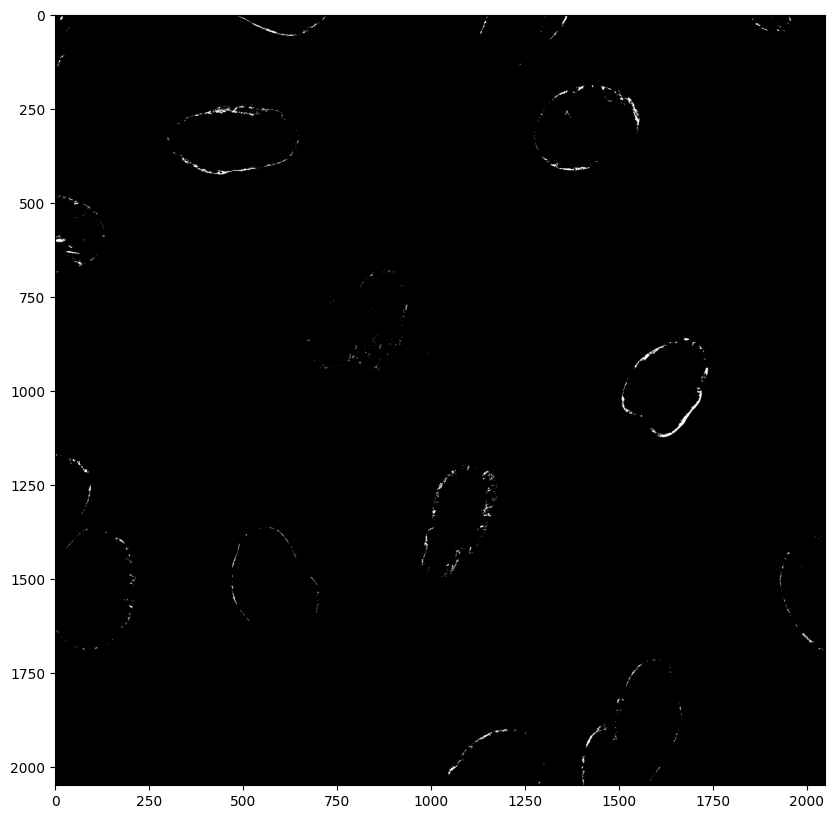

In [44]:
plt.subplots(figsize=(10,10))
plt.imshow(both_masks, cmap = 'gray')

o podemos considerar los píxeles que están ENCENDIDOS (```True```) en una **o** la otra imagen sumándolos como ```True + False = True```:

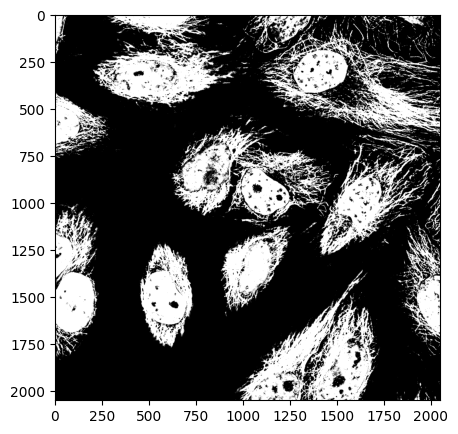

In [ ]:
plt.subplots(figsize=(5,5))
plt.imshow(mask_cells + mask_nuclei, cmap = 'gray')

Para hacer las cosas más limpias, en lugar de usar operadores como ```+``` or ```*``` podemos ser más explícitos y usar operaciones lógicas de Numpy como ```np.logical_or()```:

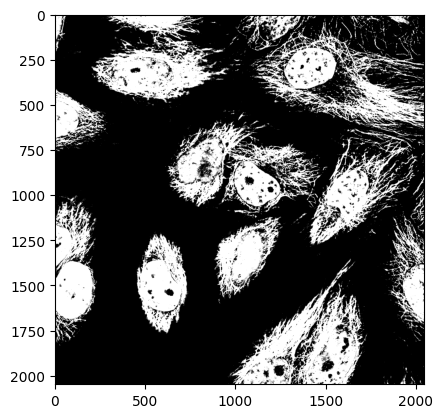

In [45]:
combine_or = np.logical_or(mask_cells, mask_nuclei)
plt.imshow(combine_or, cmap = 'gray')

Ahora que tenemos **elementos segmentados** en nuestra imagen, queremos ser capaces de cuantificar esos elementos, que es lo que se hace en el capítulo 11. En la parte 10 podemos ver cómo podemos mejorar las máscaras limpiándolas mediante operaciones binarias/morfológicas.